# Temporal Fusion Transformer (TFT)

## Why We Chose Temporal Fusion Transformer (TFT)

Our exploratory data analysis revealed several important characteristics in the Bitcoin fee series that guided our model choice:

### Key Observations from EDA
- **Strong temporal patterns**: Clear intraday cycles and short-term dependencies in fee fluctuations.
- **Volatility and sharp spikes**: Frequent, irregular surges in transaction fees make point estimation challenging.
- **Multivariate dependencies**: Fee dynamics are influenced by multiple time-varying factors with non-linear interactions.
- **Lagged effects**: Historical values of both the target and covariates impact future behavior.

### Why TFT is a Good Fit
- **Multi-horizon forecasting**: Captures both short-term spikes and longer trends in one pass.
- **Attention mechanism**: Learns which time steps and variables are most relevant at each point.
- **Static + time-varying input support**: Integrates contextual and real-time signals effectively.
- **Quantile-based loss**: Provides uncertainty-aware forecasts, especially valuable under volatile market conditions.
- **Interpretable outputs**: Offers insights into feature importance and temporal relevance.

> Given these insights, TFT stands out as a model capable of handling the complexity, volatility, and interpretability needs revealed through EDA.


## 1. Import and dataset

In [43]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from torch import Tensor
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting.metrics import MAPE, MAE, RMSE
import torch.nn as nn
import numpy as np
import os
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from pytorch_forecasting.metrics.base_metrics import Metric
torch.set_float32_matmul_precision('high')

In [2]:

df = pd.read_parquet("../data/processed/processed_tft.parquet")
df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300,time_idx,hour,minute,day_of_week,month
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,8232.000000,4.888571e+07,...,0.0,0.0,0.0,0.0,0.0,0,2,0,2,3
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,9943.333333,4.946978e+07,...,0.0,0.0,0.0,0.0,0.0,1,2,15,2,3
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,8189.333333,4.936482e+07,...,0.0,0.0,0.0,0.0,0.0,2,2,30,2,3
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,8874.666667,5.061585e+07,...,0.0,0.0,0.0,0.0,0.0,3,2,45,2,3
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,11247.333333,5.158261e+07,...,0.0,0.0,0.0,0.0,0.0,4,3,0,2,3


## 2. Train/Validation Split Strategy

To properly evaluate a time series forecasting model, we must avoid data leakage from the future into the past. Therefore, we adopt a **forward-chaining** strategy — a method that respects temporal order by always using earlier data to predict later data.

### What is Forward-Chaining?

Forward-chaining is a time series cross-validation method where each training set includes all observations up to a certain point in time, and the validation set contains only future observations. It mimics real-world deployment where predictions are always made on unseen future data based on historical information.

For example:

```
Train: [1, 2, 3, 4]      → Validate: [5]  
Train: [1, 2, 3, 4, 5]   → Validate: [6]
...
```

This avoids data leakage and ensures that validation simulates future forecasting.

---


In [21]:
FREQ                = "15min"      # Original data frequency: one data point every 15 minutes
ENC_LEN             = 672          # Input sequence length: 7 days of historical context (672 × 15min = 7 days)
PRED_STEPS          = 96           # Forecasting horizon: 1 day ahead (96 × 15min = 24 hours)
VAL_DAYS            = 1            # Validation covers the last 1 day
BATCH_SIZE          = 32
NUM_WORKERS         = 4

In [22]:
# Compute number of validation rows (96 steps per day)
VAL_WINDOW = PRED_STEPS * VAL_DAYS  # = 96

# Indices for splitting
val_start_idx = (
    df.time_idx.max() - VAL_WINDOW + 1
)  # First index of validation window
pred_start_idx = (
    df.time_idx.max() - PRED_STEPS + 1
)  # First index of the prediction window (for decoder)

# Create boolean masks
train_mask = df.time_idx < val_start_idx
val_mask = df.time_idx >= val_start_idx

# Apply masks to get train and validation subsets
df_train, df_val = df[train_mask].copy(), df[val_mask].copy()


### Why This Split Works
- Preserves the **temporal causality** of training-before-validation.
- Ensures the model learns from the past to predict the future, just like it would in production.
- Provides enough context (7 days) and a realistic forecast window (1 day) to capture daily and weekly patterns.

---

## 3. Feature Scaling with Training Data Only

To ensure that features contribute comparably to the learning process, we **standardize** all numerical input features. This is essential for models like TFT that use neural networks, as unscaled inputs can lead to unstable training.

### Why We Must Scale Using Training Data Only

When working with time series, **we must avoid leaking future information into the model**. This means:
- We compute the mean and standard deviation **only on the training set**.
- We then apply this scaling to both the training and validation sets.

This mirrors real-world deployment: at prediction time, only historical data is available to determine scaling.


In [23]:
# Columns to exclude from scaling (e.g., time and categorical identifiers)
EXCLUDE = [
    "target",
    "time_idx",
    "hour",
    "minute",
    "day_of_week",
    "month",
    "series_id",
    "timestamp",
]

# Select only continuous float features (excluding the above)
num_cols = df.select_dtypes("float64").columns.difference(EXCLUDE)

# Initialize standard scaler (z-score normalization)
scaler = StandardScaler()

# Fit on training data, then transform both train and validation sets
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_val[num_cols] = scaler.transform(df_val[num_cols])


###  Why This Step Matters
- Prevents features with large numeric ranges from dominating learning.
- Ensures consistent scale across train and validation.
- Maintains the **causal structure** by fitting only on training data, avoiding future data leakage.

---

## 4. Building the TimeSeriesDataSet for TFT

In this step, we define how to structure our data for use with the **Temporal Fusion Transformer (TFT)**. The `TimeSeriesDataSet` is a core abstraction in `pytorch-forecasting` that handles windowing, normalization, feature encoding, and sampling.

---

In [24]:
# Select real-valued covariates from mempool, difficulty, and price-related signals
real_covs = [
    c for c in df.columns if c.startswith(("mempool", "difficulty", "price"))
]

# Create training dataset object
tft_ds = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",  # Time index for temporal ordering
    target="target",  # Target variable to forecast
    group_ids=[
        "series_id"
    ],  # Series identifier (e.g., single series in our case)
    max_encoder_length=ENC_LEN,  # Input length (e.g., 7 days)
    max_prediction_length=PRED_STEPS,  # Forecast horizon (e.g., 1 day)
    static_categoricals=[
        "series_id"
    ],  # Static categorical features that don't change over time
    # Known ahead-of-time covariates (calendar-based)
    time_varying_known_reals=[
        "time_idx",
        "hour",
        "minute",
        "day_of_week",
        "month",
    ],
    # Unknown covariates — real-valued signals that the model must learn to predict
    time_varying_unknown_reals=["target"] + real_covs,
    target_normalizer=GroupNormalizer(
        groups=["series_id"]
    ),  # Normalize per-series
    add_relative_time_idx=True,  # Adds a feature counting time steps from the start of each sequence (0, 1, ..., N)
    add_target_scales=True,  # Adds the mean and std of the target per series as extra features (helps with varying scales)
    add_encoder_length=True,  # Adds the actual encoder length used in each sample (useful for variable history lengths)
)


In [25]:
# Prepare validation context (includes encoder history + prediction window)
history_start_idx = val_start_idx - ENC_LEN
val_ctx = df[df.time_idx >= history_start_idx].copy()

# Build validation TimeSeriesDataSet using the same structure
val_ds = TimeSeriesDataSet.from_dataset(
    tft_ds,
    val_ctx,
    predict_mode=True,
    min_prediction_idx=val_start_idx,  # Start of prediction window
    stop_randomization=True,  # Keep deterministic sampling for validation
)


In [26]:
# Get all real-valued features used
print("Real-valued features used:", tft_ds.reals)

# Get all categorical features used
print("\nCategorical features used:", tft_ds.categoricals)

# All columns in the original DataFrame
print("\nAll columns in df:", df.columns.tolist())

# Columns that were left out (not in reals or categoricals)
used_columns = set(tft_ds.reals + tft_ds.categoricals)
left_out_columns = set(df.columns) - used_columns

print("\nLeft-out columns:", left_out_columns)


Real-valued features used: ['encoder_length', 'target_center', 'target_scale', 'time_idx', 'hour', 'minute', 'day_of_week', 'month', 'relative_time_idx', 'target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_remainingBlocks', 'difficulty_adjustment_remainingTime', 'difficulty_adjustment_previousTime', 'difficulty_adjustment_nextRetargetHeight', 'difficulty_adjustment_timeAvg', 'difficulty_adjustment_adjustedTimeAvg', 'difficulty_adjustment_timeOffset', 'difficulty_adjustment_expectedBlocks', 'price_USD', 'mempool_fee_histogram_bin_1_2', 'mempool_fee_histogram_bin_2_3', 'mempool_fee_histogram_bin_3_4', 'mempool_fee_histogram_bin_4_5', 'mempool_fee_histogram_bin_5_6', 'mempool_fee_histogram_bin_6_7', 'mempool_fee_histogram_bin_7_8', 'mempoo

###  Why This Step Matters
- Prevents features with large numeric ranges from dominating learning.
- Ensures consistent scale across train and validation.
- Maintains the **causal structure** by fitting only on training data, avoiding future data leakage.
---

## 5. Creating DataLoaders for Training and Validation

This block prepares PyTorch DataLoaders from the `TimeSeriesDataSet`. DataLoaders efficiently feed batches into the model during training and evaluation.


In [27]:
NUM_WORKERS = min(4, os.cpu_count())  # Use up to 4 workers to balance loading speed and system stability (4 is usually enough to keep GPU busy)
# Training DataLoader
train_dl = tft_ds.to_dataloader(
    train=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    shuffle=False,  # Keep time order — no shuffling in time series
)

# Validation DataLoader
val_dl = val_ds.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE * 2,  # Larger batch OK for validation since no backprop
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    shuffle=False,  # Keep time order — still important in validation
)


### Why This Matters
- **No shuffling**: Time series data must retain order — shuffling breaks temporal relationships.
- **`persistent_workers=True`**: Keeps worker processes alive across epochs to speed up data loading.
- **Larger batch for validation**: Speeds up evaluation since gradients aren't calculated.
___

## 6. Model Configuration, Custom Loss, and Training Strategy

We define the **Temporal Fusion Transformer (TFT)** along with a custom **hybrid loss function**, learning rate scheduling, and training logic. This setup balances probabilistic accuracy with point prediction precision.


In [58]:
from typing import List, Union, Tuple
class EnhancedQuantileRMSELoss(QuantileLoss):
    """
    Enhanced quantile loss with RMSE and variability penalties to encourage 
    wave-like predictions and prevent flat outputs.
    """
    def __init__(self, 
                 quantiles: List[float] = [0.1, 0.5, 0.9], 
                 rmse_weight: float = 0.1,
                 std_penalty_weight: float = 0.05,
                 gradient_penalty_weight: float = 0.02,
                 min_std_threshold: float = 1e-3):
        super().__init__(quantiles=quantiles)
        self.rmse_weight = rmse_weight
        self.std_penalty_weight = std_penalty_weight
        self.gradient_penalty_weight = gradient_penalty_weight
        self.min_std_threshold = min_std_threshold
        self._median_idx = quantiles.index(0.5)
        
    def forward(self, y_pred: torch.Tensor, target: Union[torch.Tensor, Tuple]):
        # Handle target format
        if isinstance(target, (tuple, list)):
            target = target[0]
            
        # Compute standard quantile loss
        qloss = super().forward(y_pred, target)
        
        # Extract median prediction
        median = self._extract_median(y_pred)
        
        # Ensure target and median have compatible shapes
        target = self._align_target_shape(target, median)
        
        # Compute RMSE
        rmse = F.mse_loss(median, target, reduction="mean").sqrt()
        
        # Compute standard deviation penalty (encourage variability)
        std_penalty = self._compute_std_penalty(median)
        
        # Compute gradient penalty (encourage smoothness but not flatness)
        gradient_penalty = self._compute_gradient_penalty(median)
        
        # Combine all losses
        total_loss = (qloss + 
                     self.rmse_weight * rmse + 
                     self.std_penalty_weight * std_penalty +
                     self.gradient_penalty_weight * gradient_penalty)
        
        return total_loss
    
    def _extract_median(self, y_pred: torch.Tensor) -> torch.Tensor:
        """Extract median prediction from quantile output."""
        if y_pred.dim() == 3:
            if y_pred.size(1) == len(self.quantiles):
                return y_pred[:, self._median_idx, :]
            else:
                return y_pred[:, :, self._median_idx]
        else:
            raise ValueError("y_pred must be a 3D tensor")
    
    def _align_target_shape(self, target: torch.Tensor, median: torch.Tensor) -> torch.Tensor:
        """Align target shape with median prediction."""
        if median.dim() == 2 and target.dim() == 3 and target.size(-1) == 1:
            return target.squeeze(-1)
        return target
    
    def _compute_std_penalty(self, predictions: torch.Tensor) -> torch.Tensor:
        """Penalize low standard deviation to encourage variability."""
        # Compute std along time dimension for each batch
        std_vals = torch.std(predictions, dim=-1, keepdim=False)
        # Penalty increases as std approaches zero
        penalty = torch.exp(-std_vals / self.min_std_threshold)
        return penalty.mean()
    
    def _compute_gradient_penalty(self, predictions: torch.Tensor) -> torch.Tensor:
        """Encourage smooth but non-flat gradients."""
        # Compute first-order differences (gradients)
        gradients = predictions[:, 1:] - predictions[:, :-1]
        # Compute second-order differences (curvature)
        second_gradients = gradients[:, 1:] - gradients[:, :-1]
        
        # Penalize zero gradients (flatness) but encourage smooth changes
        gradient_penalty = torch.exp(-torch.abs(gradients).mean())
        curvature_regularization = torch.abs(second_gradients).mean()
        
        return gradient_penalty + 0.1 * curvature_regularization


class AdaptiveQuantileRMSELoss(QuantileLoss):
    """
    Adaptive version that adjusts penalties based on prediction characteristics.
    """
    def __init__(self, 
                 quantiles: List[float] = [0.1, 0.5, 0.9],
                 rmse_weight: float = 0.1,
                 variability_weight: float = 0.05,
                 adaptive_threshold: float = 0.01):
        super().__init__(quantiles=quantiles)
        self.rmse_weight = rmse_weight
        self.variability_weight = variability_weight
        self.adaptive_threshold = adaptive_threshold
        self._median_idx = quantiles.index(0.5)
        
    def forward(self, y_pred: torch.Tensor, target: Union[torch.Tensor, Tuple]):
        # Handle target format
        if isinstance(target, (tuple, list)):
            target = target[0]
            
        # Compute standard quantile loss
        qloss = super().forward(y_pred, target)
        
        # Extract median prediction
        median = self._extract_median(y_pred)
        target = self._align_target_shape(target, median)
        
        # Compute RMSE
        rmse = F.mse_loss(median, target, reduction="mean").sqrt()
        
        # Adaptive variability penalty
        variability_penalty = self._adaptive_variability_penalty(median, target)
        
        return qloss + self.rmse_weight * rmse + self.variability_weight * variability_penalty
    
    def _extract_median(self, y_pred: torch.Tensor) -> torch.Tensor:
        if y_pred.dim() == 3:
            if y_pred.size(1) == len(self.quantiles):
                return y_pred[:, self._median_idx, :]
            else:
                return y_pred[:, :, self._median_idx]
        else:
            raise ValueError("y_pred must be a 3D tensor")
    
    def _align_target_shape(self, target: torch.Tensor, median: torch.Tensor) -> torch.Tensor:
        if median.dim() == 2 and target.dim() == 3 and target.size(-1) == 1:
            return target.squeeze(-1)
        return target
    
    def _adaptive_variability_penalty(self, predictions: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """Adaptive penalty that considers target variability."""
        # Compute prediction and target variability
        pred_std = torch.std(predictions, dim=-1)
        target_std = torch.std(target, dim=-1)
        
        # Penalty when prediction std is much lower than target std
        std_ratio = pred_std / (target_std + 1e-8)
        
        # Stronger penalty for very flat predictions
        flatness_penalty = torch.exp(-pred_std / self.adaptive_threshold)
        
        # Combine penalties
        ratio_penalty = torch.clamp(1.0 - std_ratio, min=0.0)
        
        return (flatness_penalty + ratio_penalty).mean()


class WaveformQuantileLoss(QuantileLoss):
    """
    Loss function specifically designed to encourage wave-like patterns.
    """
    def __init__(self, 
                 quantiles: List[float] = [0.1, 0.5, 0.9],
                 rmse_weight: float = 0.1,
                 frequency_weight: float = 0.03,
                 amplitude_weight: float = 0.02):
        super().__init__(quantiles=quantiles)
        self.rmse_weight = rmse_weight
        self.frequency_weight = frequency_weight
        self.amplitude_weight = amplitude_weight
        self._median_idx = quantiles.index(0.5)
        
    def forward(self, y_pred: torch.Tensor, target: Union[torch.Tensor, Tuple]):
        # Handle target format
        if isinstance(target, (tuple, list)):
            target = target[0]
            
        # Compute standard quantile loss
        qloss = super().forward(y_pred, target)
        
        # Extract median prediction
        median = self._extract_median(y_pred)
        target = self._align_target_shape(target, median)
        
        # Compute RMSE
        rmse = F.mse_loss(median, target, reduction="mean").sqrt()
        
        # Encourage wave-like patterns
        frequency_penalty = self._frequency_penalty(median)
        amplitude_penalty = self._amplitude_penalty(median)
        
        return (qloss + 
                self.rmse_weight * rmse + 
                self.frequency_weight * frequency_penalty +
                self.amplitude_weight * amplitude_penalty)
    
    def _extract_median(self, y_pred: torch.Tensor) -> torch.Tensor:
        if y_pred.dim() == 3:
            if y_pred.size(1) == len(self.quantiles):
                return y_pred[:, self._median_idx, :]
            else:
                return y_pred[:, :, self._median_idx]
        else:
            raise ValueError("y_pred must be a 3D tensor")
    
    def _align_target_shape(self, target: torch.Tensor, median: torch.Tensor) -> torch.Tensor:
        if median.dim() == 2 and target.dim() == 3 and target.size(-1) == 1:
            return target.squeeze(-1)
        return target
    
    def _frequency_penalty(self, predictions: torch.Tensor) -> torch.Tensor:
        """Penalize lack of oscillatory behavior."""
        # Count sign changes in gradients (proxy for frequency content)
        gradients = predictions[:, 1:] - predictions[:, :-1]
        sign_changes = (gradients[:, 1:] * gradients[:, :-1] < 0).float()
        
        # Encourage some oscillation but not too much noise
        target_changes = predictions.size(-1) * 0.1  # Expect ~10% sign changes
        change_ratio = sign_changes.sum(dim=-1) / target_changes
        
        # Penalty for too few changes (flat) or too many changes (noisy)
        penalty = torch.abs(change_ratio - 1.0)
        return penalty.mean()
    
    def _amplitude_penalty(self, predictions: torch.Tensor) -> torch.Tensor:
        """Encourage appropriate amplitude variation."""
        # Measure peak-to-peak amplitude
        amplitude = torch.max(predictions, dim=-1)[0] - torch.min(predictions, dim=-1)[0]
        
        # Penalize very small amplitudes (flat predictions)
        min_amplitude = torch.std(predictions, dim=-1) * 2.0  # Expected minimum amplitude
        amplitude_penalty = torch.exp(-(amplitude / (min_amplitude + 1e-8)))
        
        return amplitude_penalty.mean()


# Usage examples:
def create_loss_function(loss_type: str = "enhanced", **kwargs):
    """Factory function to create different loss variants."""
    if loss_type == "enhanced":
        return EnhancedQuantileRMSELoss(**kwargs)
    elif loss_type == "adaptive":
        return AdaptiveQuantileRMSELoss(**kwargs)
    elif loss_type == "waveform":
        return WaveformQuantileLoss(**kwargs)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

We extend `QuantileLoss` by adding an RMSE penalty on the **median quantile (0.5)**:

- **Quantile Loss** encourages the model to predict across different confidence levels (0.1, 0.5, 0.9).
- **RMSE penalty** helps anchor the median prediction close to the true value, improving accuracy on the central estimate.
- Handles 3D outputs flexibly whether shape is `[batch, quantile, time]` or `[batch, time, quantile]`.

>  This hybrid loss encourages **sharp and calibrated** forecasts while improving accuracy at the center of the prediction interval.


### 6.1 TFT Model Definition

In [60]:
loss_fn = EnhancedQuantileRMSELoss(
    quantiles=[0.1, 0.5, 0.9],
    rmse_weight=0.1,
    std_penalty_weight=0.05,  # Adjust this to control variability
    gradient_penalty_weight=0.02,
    min_std_threshold=1e-3
)

tft = TemporalFusionTransformer.from_dataset(
    tft_ds,
    learning_rate=1e-4,  # Initial learning rate for optimizer
    hidden_size=32,  # Size of hidden layers (LSTM + attention); controls model capacity
    attention_head_size=4,  # Number of attention heads in the multi-head attention layer
    lstm_layers=1,  # Number of stacked LSTM layers in the encoder/decoder
    dropout=0.2,  # Dropout rate for regularization
    loss= loss_fn,
    output_size=3,  # Number of quantiles being predicted (must match loss quantiles)
    weight_decay=1e-4,  # L2 regularization to reduce overfitting
    log_interval=10,  # Log training progress every 10 batches
    reduce_on_plateau_patience=0,  # Disable built-in LR scheduler (we use our own with custom config)
)


- **Small model size** (`hidden_size=32`, `lstm_layers=1`) for efficient training and fast iteration. Can be changed to larger value if having enough computational resource
- **Quantile-based output** for predicting uncertainty ranges: 10th, 50th (median), and 90th percentiles.
- **Dropout & weight decay** to reduce overfitting.
- **Custom loss** (see above) balances distribution coverage and point accuracy.


### 6.2 Callbacks

In [53]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",  # Watch validation loss for improvements
        patience=15,  # Stop training if no improvement for 15 validation checks
        min_delta=0.003,  # Minimum change in val_loss to qualify as improvement
        mode="min",  # Lower val_loss is better
        verbose=True,  # Print early stopping messages
    ),
    LearningRateMonitor(),  # Log learning rate at each step (helps with debugging/tracking)
    ModelCheckpoint(
        dirpath="./saved_models",  # Folder to save model checkpoints
        filename="best-model-{epoch}-{val_loss:.4f}",  # File naming format
        monitor="val_loss",  # Save the model with the lowest val_loss
        save_top_k=1,  # Keep only the best model
        mode="min",  # Lower val_loss is better
        save_last=True,  # Also save the final model from the last epoch
        verbose=True,  # Print checkpoint saving messages
    ),
]

- **EarlyStopping**: Stops training when validation loss plateaus for 15 checks.
- **LearningRateMonitor**: Logs learning rate for better visibility.
- **ModelCheckpoint**: Saves best and last models by validation loss.

### 6.3 Trainer Setup

In [54]:
trainer = pl.Trainer(
    max_epochs=100,  # Train for up to 100 epochs
    accelerator="gpu",  # Use GPU for training
    devices=1,  # Use 1 GPU device
    precision="bf16-mixed",  # Use mixed precision with bfloat16 for faster training (if supported)
    gradient_clip_val=0.5,  # Clip gradients > 0.5 to avoid exploding gradients
    callbacks=callbacks,  # List of callbacks (early stopping, checkpointing, etc.)
    accumulate_grad_batches=1,  # Number of batches to accumulate before backpropagation (1 = no accumulation)
    deterministic=False,  # Set to True for reproducible results (slower); False allows faster ops
    enable_progress_bar=True,  # Show training progress bar in the notebook/console
    val_check_interval=0.5,  # Run validation 2× per epoch (every 50% of an epoch)
)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- **bf16-mixed precision** accelerates training on supported GPUs (e.g., A100, 4090).
- **Gradient clipping** improves stability on spiky updates.
- **Validation every half epoch** gives more frequent feedback during long training runs.

### 6.4 Custom Optimizer and Learning Rate Scheduler

In [55]:
def configure_optimizers_fix(self):
    optimizer = AdamW(
        self.parameters(),
        lr=1e-4,  # Base learning rate
        weight_decay=1e-4,  # L2 regularization to prevent overfitting
        eps=1e-6,  # Numerical stability
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",  # Reduce LR when validation loss stops decreasing
        factor=0.7,  # Multiply LR by 0.7 on plateau
        patience=8,  # Wait for 8 epochs with no improvement
        min_lr=1e-6,  # Set a floor for learning rate
    )

    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",  # Watch validation loss
            "interval": "epoch",  # Check scheduler every epoch
            "frequency": 1,
        },
    }


# Bind the function to the TFT instance
tft.configure_optimizers = configure_optimizers_fix.__get__(tft, type(tft))


> This is dynamically bound to the TFT instance to override its default optimizer logic.

###  Summary

This setup:
- Combines **distributional forecasting** with **point-error minimization**.
- Uses **modest architecture** for efficient experimentation.
- Integrates **robust scheduling and stopping rules** to optimize generalization.


## 7. Fit the model with datalaoders

In [ ]:
trainer.fit(tft, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | EnhancedQuantileRMSELoss        | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 20     | train
3  | prescalers                         | ModuleDict                      | 1.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 79.2 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.587
Epoch 0, global step 242: 'val_loss' reached 0.58747 (best 0.58747), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=0-val_loss=0.5875.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.094 >= min_delta = 0.003. New best score: 0.493
Epoch 0, global step 484: 'val_loss' reached 0.49344 (best 0.49344), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=0-val_loss=0.4934.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.009 >= min_delta = 0.003. New best score: 0.484
Epoch 1, global step 727: 'val_loss' reached 0.48396 (best 0.48396), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=1-val_loss=0.4840.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 969: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.003. New best score: 0.480
Epoch 2, global step 1212: 'val_loss' reached 0.47962 (best 0.47962), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=2-val_loss=0.4796.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 1454: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1697: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1939: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 2182: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 2424: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2667: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2909: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 3152: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 3394: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 3637: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 3879: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 4122: 'val_loss' reached 0.47815 (best 0.47815), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=8-val_loss=0.4782.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 4364: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.003. New best score: 0.476
Epoch 9, global step 4607: 'val_loss' reached 0.47598 (best 0.47598), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=9-val_loss=0.4760.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9, global step 4849: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10, global step 5092: 'val_loss' reached 0.47409 (best 0.47409), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=10-val_loss=0.4741.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10, global step 5334: 'val_loss' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.004 >= min_delta = 0.003. New best score: 0.472
Epoch 11, global step 5577: 'val_loss' reached 0.47227 (best 0.47227), saving model to 'C:\\Users\\davyx\\桌面\\学习\\Capstone_SatCast_Trilemma\\analysis\\saved_models\\best-model-epoch=11-val_loss=0.4723.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11, global step 5819: 'val_loss' was not in top 1


In [14]:
ckpt_path = "./saved_models/best-model-epoch=23-val_loss=0.3297.ckpt"  # pick the file you want

model = TemporalFusionTransformer.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    map_location    = "cuda"   # or "cpu"
)

model.eval()  

C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'target', 'group_ids': ['series_id'], 'weight': None, 'max_encoder_length': 672, 'min_encoder_length': 672, 'min_prediction_idx': np.int64(0), 'min_prediction_length': 96, 'max_prediction_length': 96, 'static_categoricals': ['series_id'], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx', 'hour', 'minute', 'day_of_week', 'month'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_re

In [15]:
pred = tft.predict(
    val_dl,
    mode="raw",          # median forecasts
    return_index=True,
    return_x=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [16]:
pred_tensor = pred.output.prediction.detach().cpu().numpy()
y_pred_0_1 = pred_tensor[:, :, 0]  # 0.1 quantile
y_pred_0_5 = pred_tensor[:, :, 1]  # 0.5 quantile (median)
y_pred_0_9 = pred_tensor[:, :, 2]  # 0.9 quantile
step_true = pred.x["decoder_target"].reshape(-1).cpu().numpy()

In [17]:
# 获取形状信息
batch, pred_len = pred.x["decoder_time_idx"].shape

# 1. 展平通用结构
step_timeidx = pred.x["decoder_time_idx"].reshape(-1).cpu().numpy()
step_series  = pred.x["groups"].squeeze(-1).repeat_interleave(pred_len).cpu().numpy()
step_true    = pred.x["decoder_target"].reshape(-1).cpu().numpy()

# 2. 提取三个分位点的预测值
pred_tensor = pred.output.prediction.detach().cpu().numpy()
step_pred_0_1 = pred_tensor[:, :, 0].reshape(-1)
step_pred_0_5 = pred_tensor[:, :, 1].reshape(-1)
step_pred_0_9 = pred_tensor[:, :, 2].reshape(-1)

# 3. 可选：decode 分类变量
enc = tft_ds.get_parameters()["categorical_encoders"]["series_id"]
step_series = enc.inverse_transform(step_series)

# 4. 时间戳映射
ts_lookup = df[["time_idx", "timestamp"]].drop_duplicates().set_index("time_idx")["timestamp"]
step_timestamp = ts_lookup.loc[step_timeidx].values

# 5. 构建完整 DataFrame
df_eval = pd.DataFrame({
    "timestamp" : step_timestamp,
    "time_idx"  : step_timeidx,
    "series_id" : step_series,
    "y_true"    : step_true,
    "y_pred_0_1": step_pred_0_1,
    "y_pred_0_5": step_pred_0_5,  # 中位数预测
    "y_pred_0_9": step_pred_0_9,
})
df_eval

,timestamp,time_idx,series_id,y_true,y_pred_0_1,y_pred_0_5,y_pred_0_9
0,2025-04-14 10:00:00,3872,recommended_fee_economyFee,2.000000,0.993133,1.122408,1.996705
1,2025-04-14 10:15:00,3873,recommended_fee_economyFee,2.000000,0.986807,1.112955,1.981175
2,2025-04-14 10:30:00,3874,recommended_fee_economyFee,2.000000,0.982662,1.109379,1.967331
3,2025-04-14 10:45:00,3875,recommended_fee_economyFee,1.666667,0.979893,1.106265,1.969000
4,2025-04-14 11:00:00,3876,recommended_fee_economyFee,1.000000,0.981675,1.104771,1.984058
...,...,...,...,...,...,...,...
475,2025-04-15 08:45:00,3963,recommended_fee_minimumFee,1.000000,0.965175,1.009124,1.015378
476,2025-04-15 09:00:00,3964,recommended_fee_minimumFee,1.000000,0.968307,1.009646,1.016194
477,2025-04-15 09:15:00,3965,recommended_fee_minimumFee,1.000000,0.967732,1.010193,1.013471
478,2025-04-15 09:30:00,3966,recommended_fee_minimumFee,1.000000,0.966670,1.010942,1.012653


In [18]:
metrics_per_sid = (
    df_eval.groupby("series_id")
           .apply(lambda g: pd.Series({
               "MAE" : np.abs(g.y_pred_0_5 - g.y_true).mean(),
               "RMSE": np.sqrt(((g.y_pred_0_5 - g.y_true) ** 2).mean()),
               "MAPE": (np.abs((g.y_pred_0_5 - g.y_true) / g.y_true).mean() * 100)
           }))
           .reset_index()
           .sort_values("RMSE")
)
metrics_per_sid


C:\Users\davyx\AppData\Local\Temp\ipykernel_92032\3984759347.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,series_id,MAE,RMSE,MAPE
4,recommended_fee_minimumFee,0.012768,0.013394,1.276841
0,recommended_fee_economyFee,0.262411,0.380445,17.784250
3,recommended_fee_hourFee,0.695024,0.792432,54.551147
2,recommended_fee_halfHourFee,0.899552,1.065597,55.430584
1,recommended_fee_fastestFee,0.957068,1.215336,46.335640


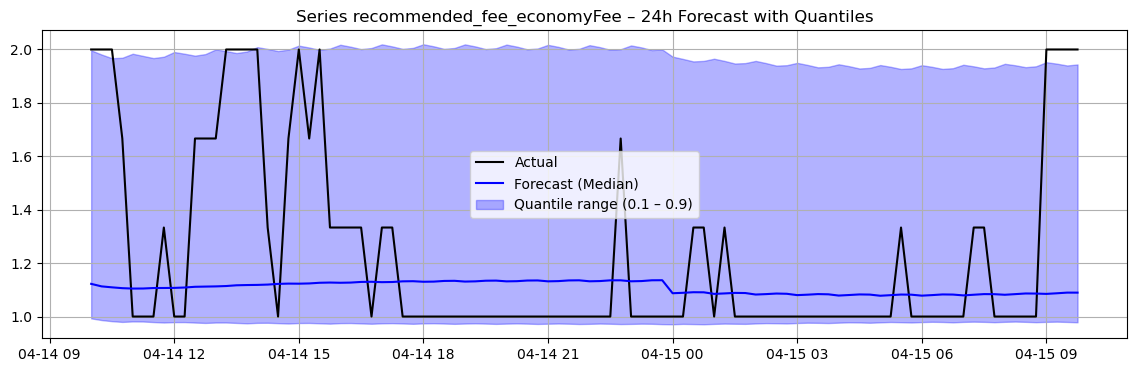

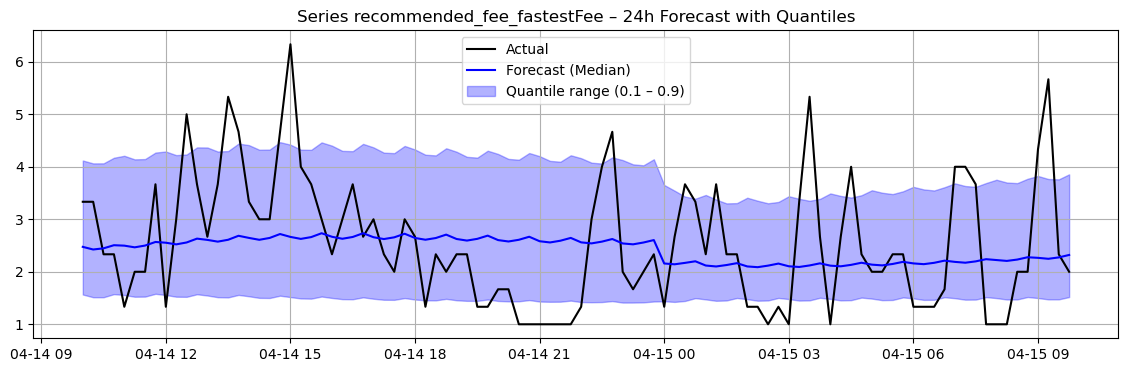

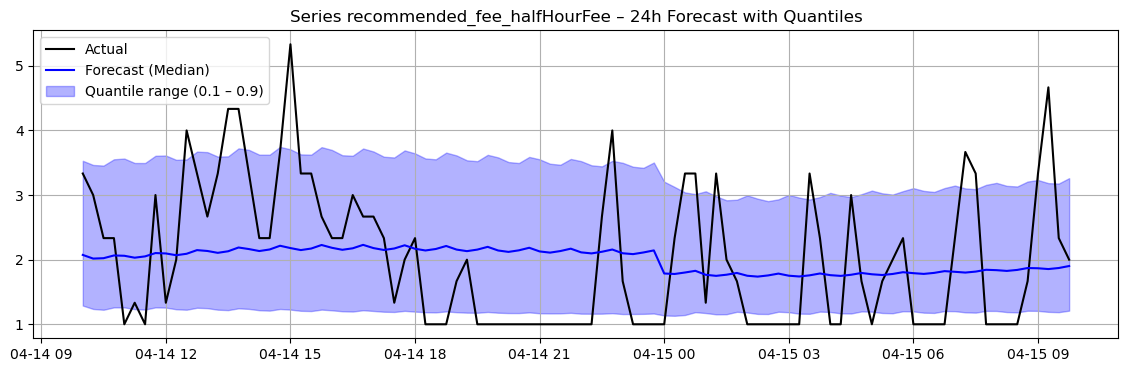

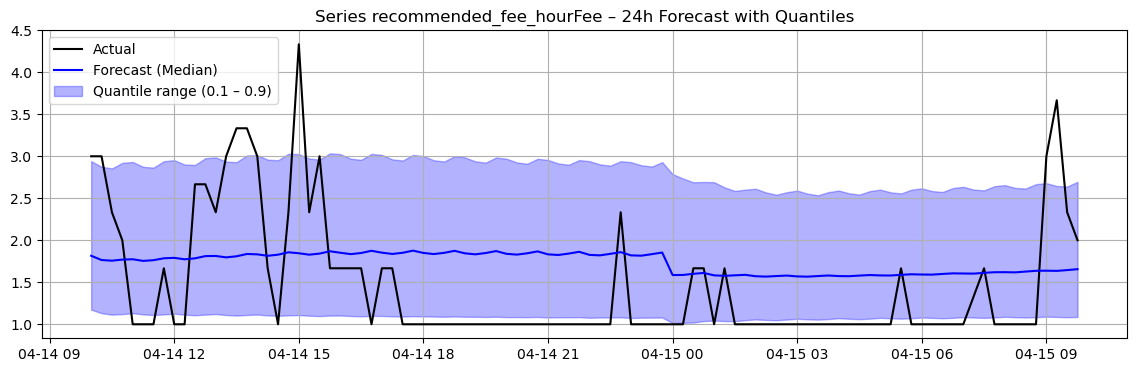

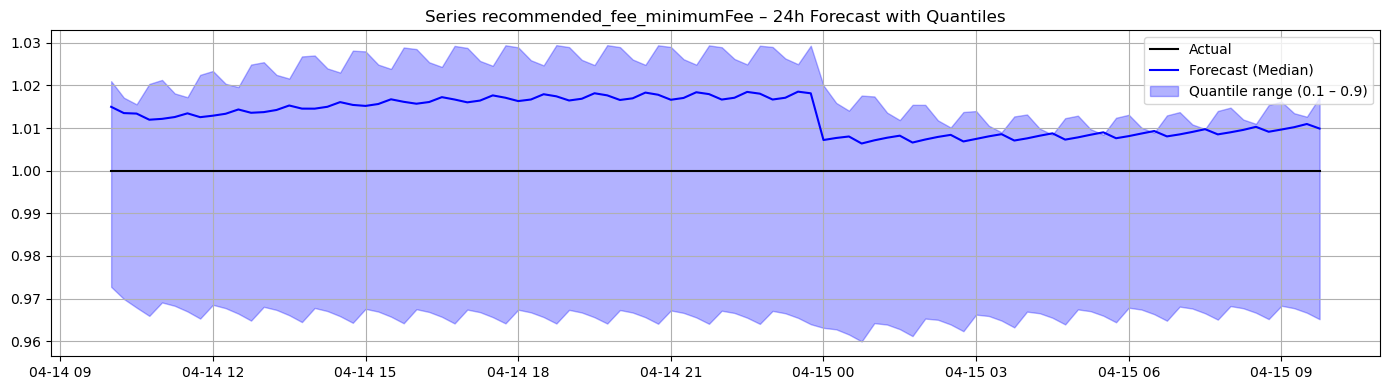

In [19]:
# ── 5 plot actual vs predicted for one or more series─────────
def plot_series(sid, ax=None):
    subset = df_eval[df_eval.series_id == sid]
    if ax is None:
        _, ax = plt.subplots(figsize=(14, 4))

    # 绘制真实值与中位预测
    ax.plot(subset.timestamp, subset.y_true, label="Actual", color="black")
    ax.plot(subset.timestamp, subset.y_pred_0_5, label="Forecast (Median)", color="blue")

    # 添加置信区间 (0.1 到 0.9)
    ax.fill_between(
        subset.timestamp,
        subset.y_pred_0_1,
        subset.y_pred_0_9,
        color="blue",
        alpha=0.3,
        label="Quantile range (0.1 – 0.9)"
    )

    ax.set_title(f"Series {sid} – 24h Forecast with Quantiles")
    ax.grid(True)
    ax.legend()
    return ax

# example: plot first two series
plot_series(df_eval.series_id.unique()[0])
plot_series(df_eval.series_id.unique()[1])
plot_series(df_eval.series_id.unique()[2])
plot_series(df_eval.series_id.unique()[3])
plot_series(df_eval.series_id.unique()[4])
plt.tight_layout()
plt.show()

In [20]:
series_ids = val_ds.index.get_level_values("series_id")      # length N
y_hat_flat  = y_hat.reshape(-1)                              # (N*96,)
y_true_flat = y_true.reshape(-1)
sid_flat    = series_ids.repeat(PRED_STEPS)

df_metrics = pd.DataFrame({
    "series_id": sid_flat.cpu().numpy(),
    "y_true"   : y_true_flat.cpu().numpy(),
    "y_pred"   : y_hat_flat.cpu().numpy()
})

def agg(g):
    err = g.y_pred - g.y_true
    abs_e = err.abs()
    return pd.Series({
        "RMSE": np.sqrt((err**2).mean()),
        "MAE" : abs_e.mean(),
        "MAPE": (abs_e / (g.y_true.abs() + 1e-9)).mean() * 100
    })

per_series = df_metrics.groupby("series_id").apply(agg)
print(per_series)

AttributeError: 'DataFrame' object has no attribute 'get_level_values'

In [ ]:
# ------------------------------------------------------------------
# 1 ── last 288 rows on a perfect grid (use ALREADY‑SCALED df_scaled)
# ------------------------------------------------------------------
def tail_grid(frame, sid, enc_len, freq):
    g = frame.query("series_id == @sid")\
            .sort_values("timestamp")

    last_ts  = g.timestamp.iat[-1]
    idx      = pd.date_range(end=last_ts, periods=enc_len, freq=freq)

    g = (g.set_index("timestamp")
           .reindex(idx)                           # pad holes
           .ffill()                                # carry everything fwd
           .bfill())

    # rebuild time_idx so it is strictly consecutive
    last_idx       = int(g.time_idx.dropna().iat[-1])
    g["time_idx"]  = np.arange(last_idx - enc_len + 1, last_idx + 1)
    return g.reset_index().rename(columns={"index": "timestamp"})

hist_tail = pd.concat(
    [tail_grid(df_scaled, sid, ENC_LEN, FREQ)
     for sid in df.series_id.unique()],
    ignore_index=True
)
hist_tail

In [ ]:

# ------------------------------------------------------------------
# 2 ── fabricate future 96 rows & scale numeric columns
# ------------------------------------------------------------------
def make_future(hist, sid, steps, freq):
    last_ts  = hist.timestamp.iat[-1]
    last_idx = hist.time_idx.iat[-1]

    fut_ts = pd.date_range(start=last_ts + pd.Timedelta(freq),
                           periods=steps, freq=freq)

    fut = pd.DataFrame({
        "timestamp" : fut_ts,
        "series_id" : sid,
        "time_idx"  : np.arange(last_idx + 1, last_idx + steps + 1,
                                dtype=np.int64),
        "target"    : np.nan
    })
    fut["hour"]        = fut.timestamp.dt.hour
    fut["minute"]      = fut.timestamp.dt.minute
    fut["day_of_week"] = fut.timestamp.dt.dayofweek
    fut["month"]       = fut.timestamp.dt.month
    return fut

future_df = pd.concat(
    [make_future(hist_tail.query("series_id == @sid"), sid, PRED_STEPS, FREQ)
     for sid in df.series_id.unique()],
    ignore_index=True
)

# carry last observed unknown‑reals into each future row
last_obs = (hist_tail.groupby("series_id")
                       .tail(1)
                       .set_index("series_id"))
for col in ["target"] + real_covs:
    future_df[col] = future_df.series_id.map(last_obs[col])

# scale numeric columns in *future* block with the SAME scaler
future_df[num_cols] = scaler.transform(future_df[num_cols])
future_df

In [ ]:
# ------------------------------------------------------------------
# 3 ── concatenate encoder + decoder part
# ------------------------------------------------------------------
predict_df = pd.concat([hist_tail, future_df], ignore_index=True)

# ensure no NaNs in encoder part
predict_df.loc[predict_df.time_idx <= hist_tail.time_idx.max(),
               ["target"] + real_covs] = (
    predict_df
      .loc[predict_df.time_idx <= hist_tail.time_idx.max(),
           ["target"] + real_covs]
      .groupby(predict_df.series_id)
      .ffill()
      .bfill()
)
predict_df

In [ ]:
# ------------------------------------------------------------------------------
# 4 ── concat history + future, ensure no NaNs remain in encoder part
# ------------------------------------------------------------------------------
predict_df = pd.concat([hist_tail, future_df], ignore_index=True)

# ensure finite targets in encoder (ffill/bfill safeguards)
predict_df[["target"] + real_covs] = (
    predict_df.groupby("series_id")[["target"] + real_covs]
              .fillna(method="ffill")
              .fillna(method="bfill")
)
predict_df

In [ ]:
# ------------------------------------------------------------------------------
# 5 ── build prediction dataset (reuse encoders, allow gaps)
# ------------------------------------------------------------------------------
pred_ds = TimeSeriesDataSet.from_dataset(
    tft_ds,                       # encoders & scalers from training
    predict_df,
    predict=True,
    stop_randomization=True,
    allow_missing_timesteps=True
)

pred_dl = pred_ds.to_dataloader(
    train=False,
    batch_size=64,
    num_workers=NUM_WORKERS
)

In [ ]:
pred = tft.predict(pred_dl, mode="prediction")      # (n_windows, 96, 1)

# metadata lives in the dataset object
idx  = pred_ds.index.reset_index(drop=True)



In [ ]:
series_order = list(df.series_id.unique())         # length = n_series
assert pred.shape[0] == len(series_order), "row‑to‑series mismatch!"

# last timestamp & time_idx per series (already in hist_tail)
last_meta = (hist_tail.groupby("series_id")
                        .agg(last_ts=("timestamp","max"),
                             last_idx=("time_idx","max")))

rows = []
for row_i, sid in enumerate(series_order):
    ts0   = last_meta.loc[sid, "last_ts"]
    idx0  = last_meta.loc[sid, "last_idx"] + 1     # first decoder step
    for step in range(PRED_STEPS):
        timestamp = ts0 + pd.Timedelta(FREQ)*(step+1)
        time_idx  = idx0 + step
        point     = pred[row_i, step].item()
        rows.append((sid, timestamp, time_idx, point))

future_forecasts = (pd.DataFrame(rows,
                                 columns=["series_id","timestamp","time_idx","pred"])
                      .sort_values(["series_id","time_idx"])
                      .reset_index(drop=True))
future_forecasts

In [ ]:
# ============================================================
#  Evaluation of 24‑hour TFT forecast
# ============================================================
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ── 1 select the actual next‑24h block ───────────────────────
last_train_idx = df.time_idx.max() - PRED_STEPS          # 24 h horizon = 96 idx
actual_24h = (
    df[df.time_idx > last_train_idx]                     # 96 rows per series
      .loc[:, ["series_id", "timestamp", "time_idx", "target"]]
      .reset_index(drop=True)
)

# sanity: should match the forecast horizon exactly
assert (actual_24h.groupby("series_id").size() == PRED_STEPS).all()
actual_24h

In [ ]:
# ── 2 merge forecast and actuals ─────────────────────────────
eval_df = (future_forecasts
           .merge(actual_24h,
                  on=["series_id", "time_idx", "timestamp"],
                  how="inner",
                  suffixes=("_pred", "_actual"))
           .sort_values(["series_id", "time_idx"]))
eval_df

In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = []
for sid, g in eval_df.groupby("series_id"):
    y_true, y_pred = g.target.values, g.pred.values
    metrics.append({
        "series_id": sid,
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAE" : mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred)
    })
metrics_df = pd.DataFrame(metrics)

# overall (pooled) error
overall = {
    "series_id": "ALL",
    "RMSE": root_mean_squared_error(eval_df.target, eval_df.pred),
    "MAE" : mean_absolute_error(eval_df.target, eval_df.pred),
    "MAPE": mape(eval_df.target, eval_df.pred)
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall])], ignore_index=True)

print(metrics_df.round(4))